In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import re
import warnings
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import TextBlob
movies = pd.read_csv('/content/movies.csv')
movies.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


MOVIES         YEAR  \
0                        Blood Red Sky       (2021)   
1  Masters of the Universe: Revelation     (2021– )   
2                     The Walking Dead  (2010–2022)   
3                       Rick and Morty     (2013– )   
4                      Army of Thieves       (2021)   

                                        GENRE  RATING  \
0      \nAction, Horror, Thriller                 6.1   
1  \nAnimation, Action, Adventure                 5.0   
2       \nDrama, Horror, Thriller                 8.2   
3  \nAnimation, Adventure, Comedy                 9.2   
4         \nAction, Crime, Horror                 NaN   

                                            ONE-LINE  \
0  \nA woman with a mysterious illness is forced ...   
1  \nThe war for Eternia begins again in what may...   
2  \nSheriff Deputy Rick Grimes wakes up from a c...   
3  \nAn animated series that follows the exploits...   
4  \nA prequel, set before the events of Army of ...   

                                               STARS    VOTES  RunTime Gross  
0  \n    Director:\nPeter Thorwarth\n| \n    Star...   21,062    121.0   NaN  
1  \n            \n    Stars:\nChris Wood, \nSara...   17,870     25.0   NaN  
2  \n            \n    Stars:\nAndrew Lincoln, \n...  885,805     44.0   NaN  
3  \n            \n    Stars:\nJustin Roiland, \n...  414,849     23.0   NaN  
4  \n    Director:\nMatthias Schweighöfer\n| \n  ...      NaN      NaN   NaN

# Task 1: Implement the data cleaning and preprocessing steps you would take on this movies dataset to prepare it for model training.

1. Describe and implement techniques for imputing or removing missing data.
2. Identify and treat outliers, particularly in numerical fields such as ratings or release years.
3. Standardize inconsistent data formats (e.g., release dates, ratings).
4. Extract and engineer features from attributes like movie titles, genres, and cast
information. For example, consider methods for parsing multiple genres or extracting
meaningful keywords from titles.


First Remove the easy duplicates

In [ ]:
movies_new = movies.drop_duplicates()

Had to drop Gross column because there were 95.19 percent values that are null

In [ ]:
movies_new.drop(columns=['Gross'], inplace=True)
movies_new.reset_index(drop=True, inplace=True)

<ipython-input-3-bf976d840947>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new.drop(columns=['Gross'], inplace=True)


Standardize inconsistent data formats

In [ ]:
movies_new['MOVIES'] = movies_new['MOVIES'].str.strip()  # Remove leading/trailing spaces
movies_new['RATING'] = pd.to_numeric(movies_new['RATING'], errors='coerce')
movies_new['YEAR'] = movies_new['YEAR'].astype(str).str.extract('(\d{4})').astype(float)
movies_new['VOTES'] = pd.to_numeric(movies_new['VOTES'], errors='coerce')

<ipython-input-4-2bee72ca1fdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['MOVIES'] = movies_new['MOVIES'].str.strip()  # Remove leading/trailing spaces
<ipython-input-4-2bee72ca1fdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['RATING'] = pd.to_numeric(movies_new['RATING'], errors='coerce')
<ipython-input-4-2bee72ca1fdb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Checking how many of the rows have near duplicates

In [ ]:
len(movies_new['MOVIES']) - movies_new['MOVIES'].nunique()

3145

Logic for Handling Near by Duplicates


*   First sort the dataset by RATING and YEAR in descending order.

*   Then, drop duplicates based on MOVIES, keeping the first occurrence (highest rating and latest year).

In [ ]:
filtered_movies = movies_new.sort_values(by=['RATING', 'YEAR'], ascending=[False, False]).drop_duplicates(subset=['MOVIES'], keep='first')

In [ ]:
filtered_movies

MOVIES    YEAR  \
7578                            BoJack Horseman  2014.0   
8392                 Avatar: The Last Airbender  2005.0   
9504                                     Dexter  2006.0   
8423                        The Midnight Gospel  2020.0   
8511         She-Ra and the Princesses of Power  2018.0   
...                                         ...     ...   
6457                Untitled Hend Sabry Project     NaN   
6470       The Kane Chronicles: The Red Pyramid     NaN   
6471    The Kane Chronicles: The Throne of Fire     NaN   
6472  The Kane Chronicles: The Serpent's Shadow     NaN   
9294                       God's Favorite Idiot     NaN   

                                           GENRE  RATING  \
7578      \nAnimation, Comedy, Drama                 9.9   
8392  \nAnimation, Action, Adventure                 9.9   
9504         \nCrime, Drama, Mystery                 9.8   
8423  \nAnimation, Adventure, Comedy                 9.7   
8511  \nAnimation, Action, Adventure                 9.7   
...                                          ...     ...   
6457                 \nComedy, Drama                 NaN   
6470      \nAction, Adventure, Drama                 NaN   
6471      \nAction, Adventure, Drama                 NaN   
6472      \nAction, Adventure, Drama                 NaN   
9294                        \nComedy                 NaN   

                                               ONE-LINE  \
7578      \nBoJack reconnects with faces from his past.   
8392  \nAang's moment of truth arrives. Can he defea...   
9504  \nDexter and Arthur find themselves on a colli...   
8423  \nClancy joins his mother on an emotional jour...   
8511  \nAdora surrenders herself to Horde Prime, hop...   
...                                                 ...   
6457                                     \nAdd a Plot\n   
6470                                     \nAdd a Plot\n   
6471                                     \nAdd a Plot\n   
6472                                     \nAdd a Plot\n   
9294                                     \nAdd a Plot\n   

                                                  STARS  VOTES  RunTime  
7578  \n    Director:\nAmy Winfrey\n| \n    Stars:\n...    NaN     26.0  
8392  \n    Director:\nJoaquim Dos Santos\n| \n    S...    NaN     92.0  
9504  \n    Director:\nSteve Shill\n| \n    Stars:\n...    NaN     51.0  
8423  \n    Directors:\nPendleton Ward, \nMike L. Ma...    NaN     36.0  
8511  \n    Directors:\nRoy Burdine, \nJen Bennett\n...    NaN     24.0  
...                                                 ...    ...      ...  
6457            \n            \n    Star:\nHend Sabry\n    NaN      NaN  
6470                                                 \n    NaN      NaN  
6471                                                 \n    NaN      NaN  
6472                                                 \n    NaN      NaN  
9294  \n            \n    Stars:\nLeslie Bibb, \nMel...    NaN      NaN  

[6423 rows x 8 columns]

In [ ]:
filtered_movies['is_duplicate'] = filtered_movies.duplicated(subset=['MOVIES'], keep=False)
filtered_movies['is_duplicate'].value_counts()

is_duplicate
False    6423
Name: count, dtype: int64

In [ ]:
filtered_movies.reset_index(drop=True, inplace=True)

In [ ]:
filtered_movies

MOVIES    YEAR  \
0                               BoJack Horseman  2014.0   
1                    Avatar: The Last Airbender  2005.0   
2                                        Dexter  2006.0   
3                           The Midnight Gospel  2020.0   
4            She-Ra and the Princesses of Power  2018.0   
...                                         ...     ...   
6418                Untitled Hend Sabry Project     NaN   
6419       The Kane Chronicles: The Red Pyramid     NaN   
6420    The Kane Chronicles: The Throne of Fire     NaN   
6421  The Kane Chronicles: The Serpent's Shadow     NaN   
6422                       God's Favorite Idiot     NaN   

                                           GENRE  RATING  \
0         \nAnimation, Comedy, Drama                 9.9   
1     \nAnimation, Action, Adventure                 9.9   
2            \nCrime, Drama, Mystery                 9.8   
3     \nAnimation, Adventure, Comedy                 9.7   
4     \nAnimation, Action, Adventure                 9.7   
...                                          ...     ...   
6418                 \nComedy, Drama                 NaN   
6419      \nAction, Adventure, Drama                 NaN   
6420      \nAction, Adventure, Drama                 NaN   
6421      \nAction, Adventure, Drama                 NaN   
6422                        \nComedy                 NaN   

                                               ONE-LINE  \
0         \nBoJack reconnects with faces from his past.   
1     \nAang's moment of truth arrives. Can he defea...   
2     \nDexter and Arthur find themselves on a colli...   
3     \nClancy joins his mother on an emotional jour...   
4     \nAdora surrenders herself to Horde Prime, hop...   
...                                                 ...   
6418                                     \nAdd a Plot\n   
6419                                     \nAdd a Plot\n   
6420                                     \nAdd a Plot\n   
6421                                     \nAdd a Plot\n   
6422                                     \nAdd a Plot\n   

                                                  STARS  VOTES  RunTime  \
0     \n    Director:\nAmy Winfrey\n| \n    Stars:\n...    NaN     26.0   
1     \n    Director:\nJoaquim Dos Santos\n| \n    S...    NaN     92.0   
2     \n    Director:\nSteve Shill\n| \n    Stars:\n...    NaN     51.0   
3     \n    Directors:\nPendleton Ward, \nMike L. Ma...    NaN     36.0   
4     \n    Directors:\nRoy Burdine, \nJen Bennett\n...    NaN     24.0   
...                                                 ...    ...      ...   
6418            \n            \n    Star:\nHend Sabry\n    NaN      NaN   
6419                                                 \n    NaN      NaN   
6420                                                 \n    NaN      NaN   
6421                                                 \n    NaN      NaN   
6422  \n            \n    Stars:\nLeslie Bibb, \nMel...    NaN      NaN   

      is_duplicate  
0            False  
1            False  
2            False  
3            False  
4            False  
...            ...  
6418         False  
6419         False  
6420         False  
6421         False  
6422         False  

[6423 rows x 9 columns]

Preprocessing and Cleaning the text data to extract from attributes like cleaned one liner, genres, and cast
information.

In [ ]:
# Function to clean the GENRE column
def clean_genre(text):
    if pd.isna(text):
        return ""
    text = text.lstrip(", ")  # Remove extra comma at the start
    text = re.sub(r',\s*,+', ',', text)  # Remove extra commas
    text = re.sub(r'\s*,\s*', ',', text)  # Remove spaces around commas
    text = re.sub(r'\n', ' ', text)  # Remove '\n' (new line) characters
    text = text.strip()  # Trim leading/trailing spaces
    return text

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Remove stop words
stop_words = set(stopwords.words('english'))

# Function to clean the STARS column and separate Director and Stars
def clean_stars(text):
    if pd.isna(text):
        return ""

    text = text.lstrip(", ")  # Remove extra comma at the start
    text = re.sub(r':,\s*', ': ', text)  # Remove comma immediately after ':'
    text = re.sub(r'\n', ' ', text)  # Remove '\n' (new line) characters
    text = re.sub(r'\|', ' ', text)  # Replace '|' with a space
    text = re.sub(r',\s*,+', ',', text)  # Remove extra commas
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces

    # Separate Director and Stars based on the "Director:" and "Stars:" keywords
    director_match = re.search(r'Director:\s*([A-Za-z\s]+)', text)  # Match Director name
    stars_match = re.search(r'Stars?:\s*([A-Za-z\s,()]+)', text)  # Match Stars names

    director = director_match.group(1).strip() if director_match else ""  # Extract Director
    stars = stars_match.group(1).strip() if stars_match else ""  # Extract Stars

    return director, stars

# Function to clean the ONE-LINE column
def clean_one_line(text):
    if pd.isna(text):
        return ""
    text = text.lstrip(", ")  # Remove extra comma at the start
    text = re.sub(r'\n', ' ', text)  # Remove '\n' (new line) characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# Apply cleaning functions to each column
filtered_movies['GENRE'] = filtered_movies['GENRE'].apply(clean_genre)  # Fix genres
filtered_movies[['Director', 'Stars']] = pd.DataFrame(filtered_movies['STARS'].apply(clean_stars).tolist(), index=filtered_movies.index)
filtered_movies['ONE-LINE'] = filtered_movies['ONE-LINE'].apply(clean_one_line)  # Fix plot summary
filtered_movies['cleaned_one_liner'] = filtered_movies['ONE-LINE'].apply(preprocess_text)
filtered_movies['cleaned_one_liner'] = filtered_movies['cleaned_one_liner'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))


filtered_movies = filtered_movies.drop(columns=['STARS'])  # Drop the original 'STARS' column

Verify Cleaned Data

In [ ]:
print(filtered_movies[['GENRE', 'Director', 'Stars', 'ONE-LINE']].head())

                        GENRE                  Director  \
0      Animation,Comedy,Drama         Amy Winfrey Stars   
1  Animation,Action,Adventure  Joaquim Dos Santos Stars   
2         Crime,Drama,Mystery         Steve Shill Stars   
3  Animation,Adventure,Comedy                             
4  Animation,Action,Adventure                             

                                               Stars  \
0      Will Arnett, Amy Sedaris, Alison Brie, Paul F   
1  Zach Tyler, Mae Whitman, Jack De Sena, Michael...   
2                                          Michael C   
3  Joey Diaz, Deneen Fendig, Phil Hendrie, Steve ...   
4  Aimee Carrero, Karen Fukuhara, AJ Michalka, Ma...   

                                            ONE-LINE  
0        BoJack reconnects with faces from his past.  
1  Aang's moment of truth arrives. Can he defeat ...  
2  Dexter and Arthur find themselves on a collisi...  
3  Clancy joins his mother on an emotional journe...  
4  Adora surrenders herself to Ho

Find Null Values percentages of each column in the entire dataset

In [ ]:
filtered_movies.isnull().sum() / len(filtered_movies) * 100

MOVIES                0.000000
YEAR                  7.924646
GENRE                 0.000000
RATING               14.089989
ONE-LINE              0.000000
VOTES                62.042659
RunTime              21.423011
is_duplicate          0.000000
Director              0.000000
Stars                 0.000000
cleaned_one_liner     0.000000
dtype: float64

Describe and implement techniques for imputing or removing missing data.

In [ ]:
filtered_movies['RunTime'] = filtered_movies['RunTime'].fillna(filtered_movies['RunTime'].median())
filtered_movies['RATING'].fillna(filtered_movies['RATING'].mean(), inplace=True)
filtered_movies['VOTES'] = filtered_movies['VOTES'].fillna(filtered_movies['VOTES'].median())

<ipython-input-14-7c1903ca41e3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_movies['RATING'].fillna(filtered_movies['RATING'].mean(), inplace=True)


# Identify and treat outliers

1. Identification of Outliers
2. Verification after Outliers Removal

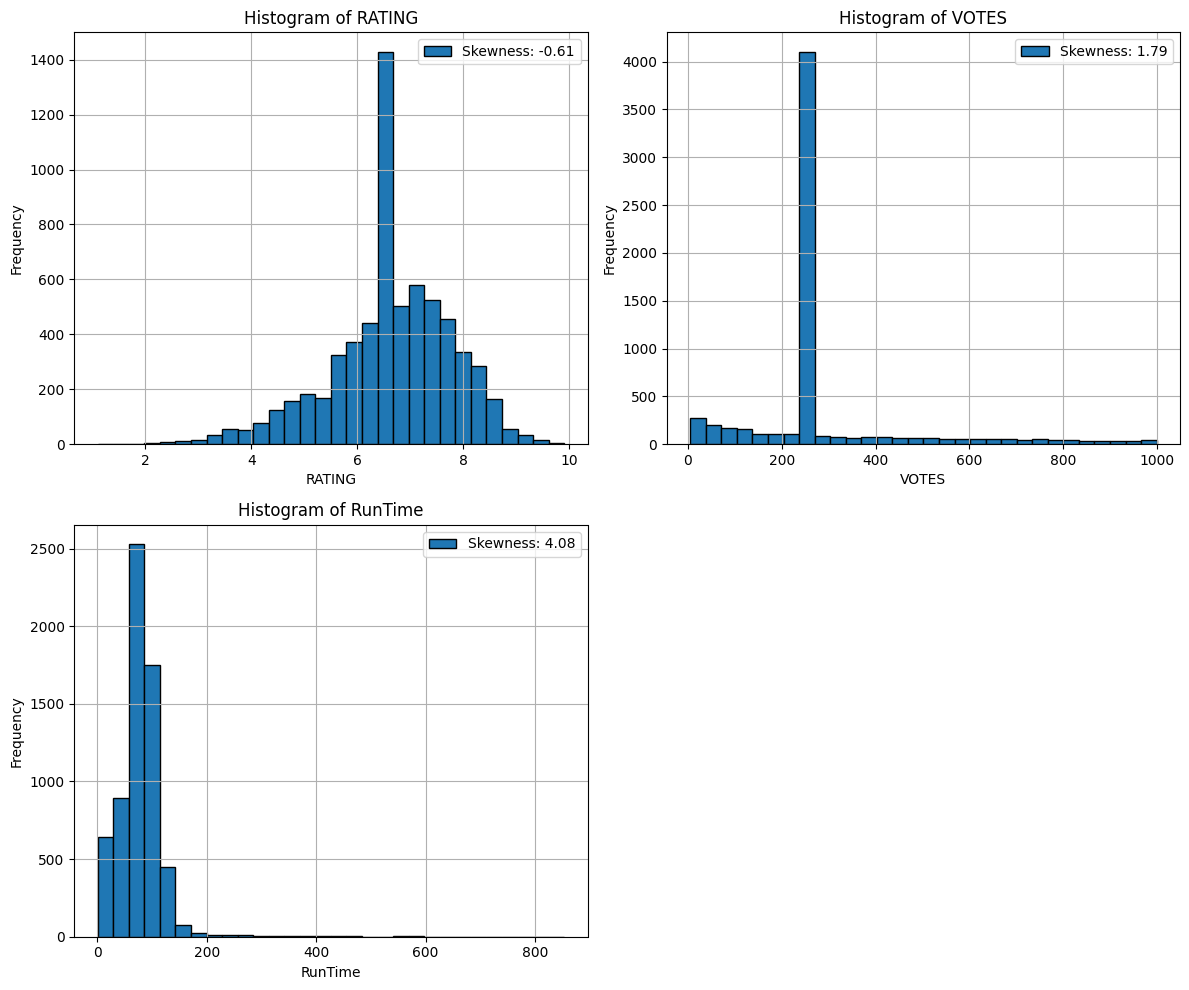

In [ ]:
columns = ['RATING', 'VOTES', 'RunTime']
plt.figure(figsize=(12, 10))
# Plot histograms with skewness values
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data = filtered_movies[col]
    skewness = skew(data)
    data.hist(bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend([f'Skewness: {skewness:.2f}'])

plt.tight_layout()
plt.show()

Outlier Identification Hypothesis
*  
    1. Movies before 1900 are usually not common and Movies dated beyond 2025 are likely incorrect.
    2. Ratings are usually on a 1-10 scale. Any value outside this range is likely a data entry error.
    3. RunTime is right-skewed. Using IQR helps remove extreme outliers without affecting the majority of movies.
    4. Votes are moderately skewed so don't need to handle them


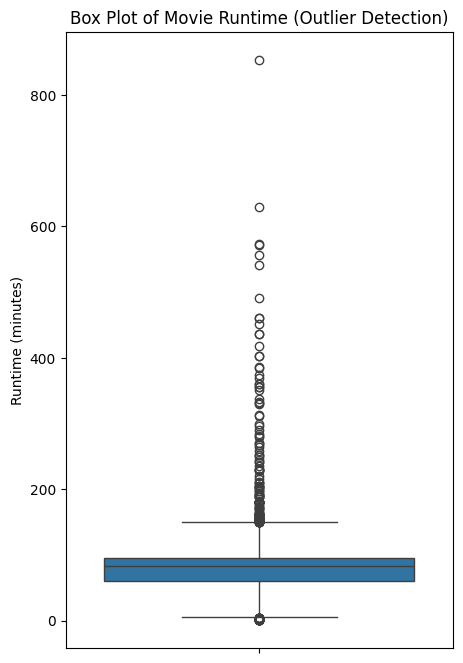

In [ ]:

plt.figure(figsize=(5, 8))
# Create the box plot
ax = sns.boxplot(y=filtered_movies['RunTime'])
# Calculate key stats
Q1 = filtered_movies['RunTime'].quantile(0.25)
Q3 = filtered_movies['RunTime'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = filtered_movies[(filtered_movies['RunTime'] < lower_bound) | (filtered_movies['RunTime'] > upper_bound)]['RunTime']
# Add title and labels
plt.title("Box Plot of Movie Runtime (Outlier Detection)")
plt.ylabel("Runtime (minutes)")

plt.show()


In [ ]:
filtered_movies

MOVIES    YEAR  \
0                               BoJack Horseman  2014.0   
1                    Avatar: The Last Airbender  2005.0   
2                                        Dexter  2006.0   
3                           The Midnight Gospel  2020.0   
4            She-Ra and the Princesses of Power  2018.0   
...                                         ...     ...   
6418                Untitled Hend Sabry Project     NaN   
6419       The Kane Chronicles: The Red Pyramid     NaN   
6420    The Kane Chronicles: The Throne of Fire     NaN   
6421  The Kane Chronicles: The Serpent's Shadow     NaN   
6422                       God's Favorite Idiot     NaN   

                           GENRE    RATING  \
0         Animation,Comedy,Drama  9.900000   
1     Animation,Action,Adventure  9.900000   
2            Crime,Drama,Mystery  9.800000   
3     Animation,Adventure,Comedy  9.700000   
4     Animation,Action,Adventure  9.700000   
...                          ...       ...   
6418                Comedy,Drama  6.643458   
6419      Action,Adventure,Drama  6.643458   
6420      Action,Adventure,Drama  6.643458   
6421      Action,Adventure,Drama  6.643458   
6422                      Comedy  6.643458   

                                               ONE-LINE  VOTES  RunTime  \
0           BoJack reconnects with faces from his past.  265.0     26.0   
1     Aang's moment of truth arrives. Can he defeat ...  265.0     92.0   
2     Dexter and Arthur find themselves on a collisi...  265.0     51.0   
3     Clancy joins his mother on an emotional journe...  265.0     36.0   
4     Adora surrenders herself to Horde Prime, hopin...  265.0     24.0   
...                                                 ...    ...      ...   
6418                                         Add a Plot  265.0     84.0   
6419                                         Add a Plot  265.0     84.0   
6420                                         Add a Plot  265.0     84.0   
6421                                         Add a Plot  265.0     84.0   
6422                                         Add a Plot  265.0     84.0   

      is_duplicate                  Director  \
0            False         Amy Winfrey Stars   
1            False  Joaquim Dos Santos Stars   
2            False         Steve Shill Stars   
3            False                             
4            False                             
...            ...                       ...   
6418         False                             
6419         False                             
6420         False                             
6421         False                             
6422         False                             

                                                  Stars  \
0         Will Arnett, Amy Sedaris, Alison Brie, Paul F   
1     Zach Tyler, Mae Whitman, Jack De Sena, Michael...   
2                                             Michael C   
3     Joey Diaz, Deneen Fendig, Phil Hendrie, Steve ...   
4     Aimee Carrero, Karen Fukuhara, AJ Michalka, Ma...   
...                                                 ...   
6418                                         Hend Sabry   
6419                                                      
6420                                                      
6421                                                      
6422  Leslie Bibb, Melissa McCarthy, Kevin Dunn, Ben...   

                                      cleaned_one_liner  
0                          bojack reconnects faces past  
1     aangs moment truth arrives defeat ozai phoenix...  
2     dexter arthur find collision course debra unea...  
3     clancy joins mother emotional journey wondrous...  
4     adora surrenders horde prime hoping buy time e...  
...                                                 ...  
6418                                           add plot  
6419                                           add plot  
6420                                           add plot  
6421        

Identify and treat outliers, particularly in numerical fields such as ratings or release years.

In [ ]:
filtered_movies = filtered_movies[(filtered_movies['YEAR'] >= 1900) & (filtered_movies['YEAR'] <= 2025)]
filtered_movies = filtered_movies[(filtered_movies['RATING'] >= 1) & (filtered_movies['RATING'] <= 10)]
def remove_outliers(movies, column):
    Q1 = movies[column].quantile(0.25)
    Q3 = movies[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return movies[(movies[column] >= lower_bound) & (movies[column] <= upper_bound)]

filtered_movies = remove_outliers(filtered_movies, 'RunTime')

In [ ]:
filtered_movies

MOVIES    YEAR  \
0                                       BoJack Horseman  2014.0   
1                            Avatar: The Last Airbender  2005.0   
2                                                Dexter  2006.0   
3                                   The Midnight Gospel  2020.0   
4                    She-Ra and the Princesses of Power  2018.0   
...                                                 ...     ...   
5909                                        As We Sleep  2002.0   
5910                                       My First Day  2001.0   
5911                                The House of Spirit  2001.0   
5912  Graffiti Verité 3: A Voyage Into the Iconograp...  2000.0   
5913                                     Magic 4 Morons  2000.0   

                           GENRE    RATING  \
0         Animation,Comedy,Drama  9.900000   
1     Animation,Action,Adventure  9.900000   
2            Crime,Drama,Mystery  9.800000   
3     Animation,Adventure,Comedy  9.700000   
4     Animation,Action,Adventure  9.700000   
...                          ...       ...   
5909                              6.643458   
5910                Short,Family  6.643458   
5911           Documentary,Short  6.643458   
5912           Documentary,Music  6.643458   
5913                      Family  6.643458   

                                               ONE-LINE  VOTES  RunTime  \
0           BoJack reconnects with faces from his past.  265.0     26.0   
1     Aang's moment of truth arrives. Can he defeat ...  265.0     92.0   
2     Dexter and Arthur find themselves on a collisi...  265.0     51.0   
3     Clancy joins his mother on an emotional journe...  265.0     36.0   
4     Adora surrenders herself to Horde Prime, hopin...  265.0     24.0   
...                                                 ...    ...      ...   
5909                                         Add a Plot  265.0     84.0   
5910  Buddy Bear is afraid of attending his first da...  265.0     30.0   
5911  Shao Fang and her late husband, Sheng Pao, wer...  265.0     43.0   
5912  This experimental musical opus probes the soci...  265.0     54.0   
5913  Magic 4 Morons teaches the viewer 10 amazing m...  265.0     60.0   

      is_duplicate                  Director  \
0            False         Amy Winfrey Stars   
1            False  Joaquim Dos Santos Stars   
2            False         Steve Shill Stars   
3            False                             
4            False                             
...            ...                       ...   
5909         False        Elizabeth Mcdonald   
5910         False                    John P   
5911         False              Weimin Zhang   
5912         False           Bob Bryan Stars   
5913         False        Rick Pamplin Stars   

                                                  Stars  \
0         Will Arnett, Amy Sedaris, Alison Brie, Paul F   
1     Zach Tyler, Mae Whitman, Jack De Sena, Michael...   
2                                             Michael C   
3     Joey Diaz, Deneen Fendig, Phil Hendrie, Steve ...   
4     Aimee Carrero, Karen Fukuhara, AJ Michalka, Ma...   
...                                                 ...   
5909                                                      
5910  Arturo Gil, Michael Munoz, Farah Bunch, Erin E...   
5911                                                      
5912                         Bruin, Chaz, Man One, Mare   
5913  Eric Miles, Tim Scarbrough, Kristin Stone, Mic...   

                                      cleaned_one_liner  
0                          bojack reconnects faces past  
1     aangs moment truth arrives defeat ozai phoenix...  
2     dexter arthur find collision course debra unea...  
3     clancy joins mother emotional journey wondrous...  
4     adora surrenders horde prime hoping buy time e...  
...                                                 ...  
5909                                           add plot  
5910  buddy bear afraid attending first 

1.1 9.9


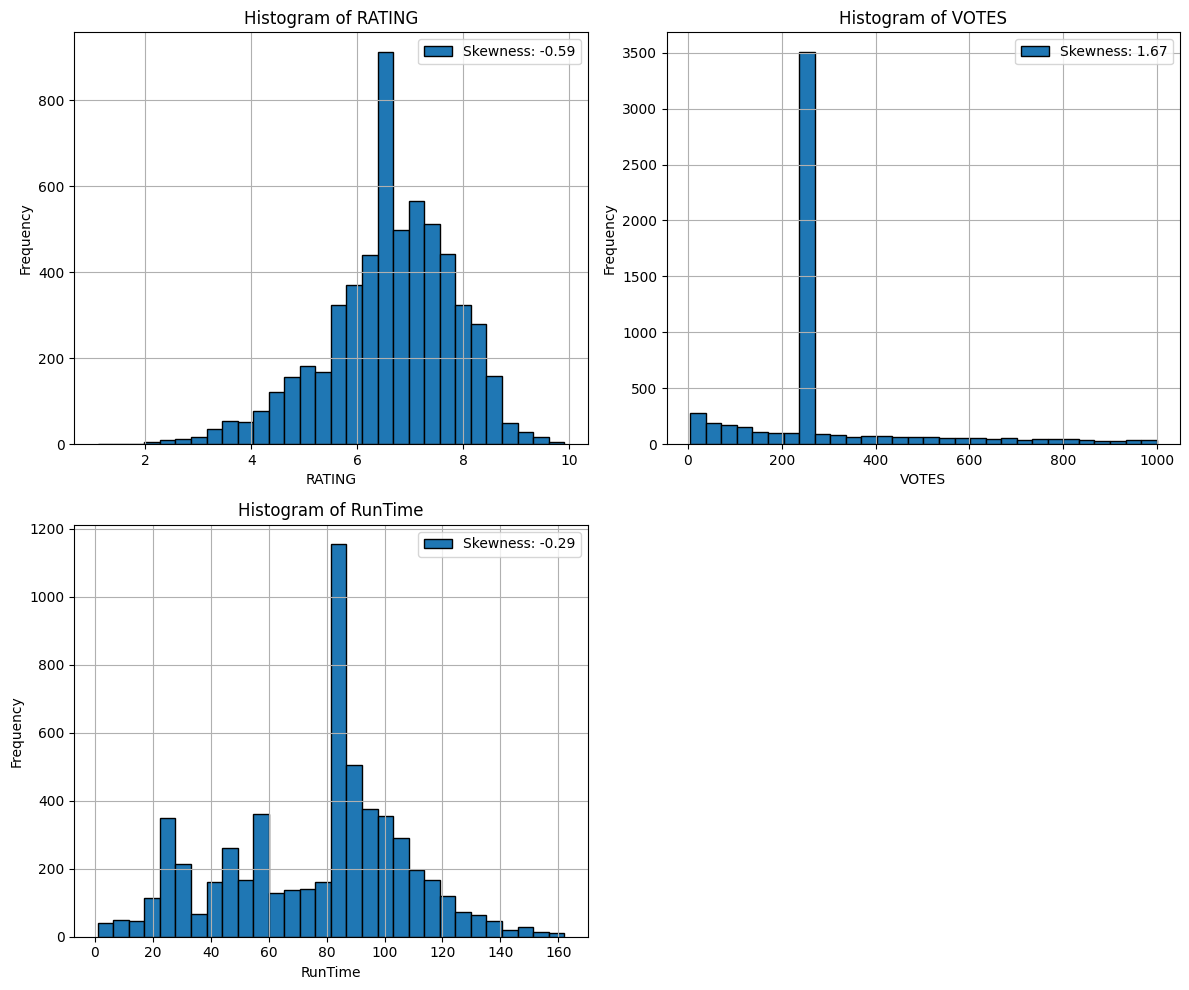

In [ ]:
print(filtered_movies['RATING'].min(), filtered_movies['RATING'].max())

columns = ['RATING', 'VOTES', 'RunTime']
plt.figure(figsize=(12, 10))
# Plot histograms with skewness values
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data = filtered_movies[col]
    skewness = skew(data)
    data.hist(bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend([f'Skewness: {skewness:.2f}'])

plt.tight_layout()
plt.show()


# Task 3: Outline the exploratory data analysis steps you would take on this dataset. Your analysis should include:
1. Identify which visualizations (e.g., histograms, boxplots, scatter plots, correlation heatmaps) you would create to understand the distribution of ratings, release years, genre frequencies, and other key attributes

2. Explain how the insights gained from your EDA would guide your feature engineering efforts and influence your model selection process



EDA and Feature Engineering

1. Genre Distribution
2. Genre Popularity and Cinema ERA (year) relationship
3. Genre and Runtime relationship
4. One Liner Summary Sentiment Scores
5. Word Cloud Generator
6. Popular Keyword Extraction
7. One Hot Encoding of Genres
8. Genre Pairwise Correlation Heatmap
9. Finalizing Features









<ipython-input-21-f1dfbce013c2>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_rated_movies = filtered_movies.groupby("GENRE", group_keys=False).apply(lambda x: x.nlargest(1, "RATING")).reset_index(drop=True)
<ipython-input-21-f1dfbce013c2>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rating_by_era = filtered_movies.groupby('ERA')['RATING'].mean().reset_index()


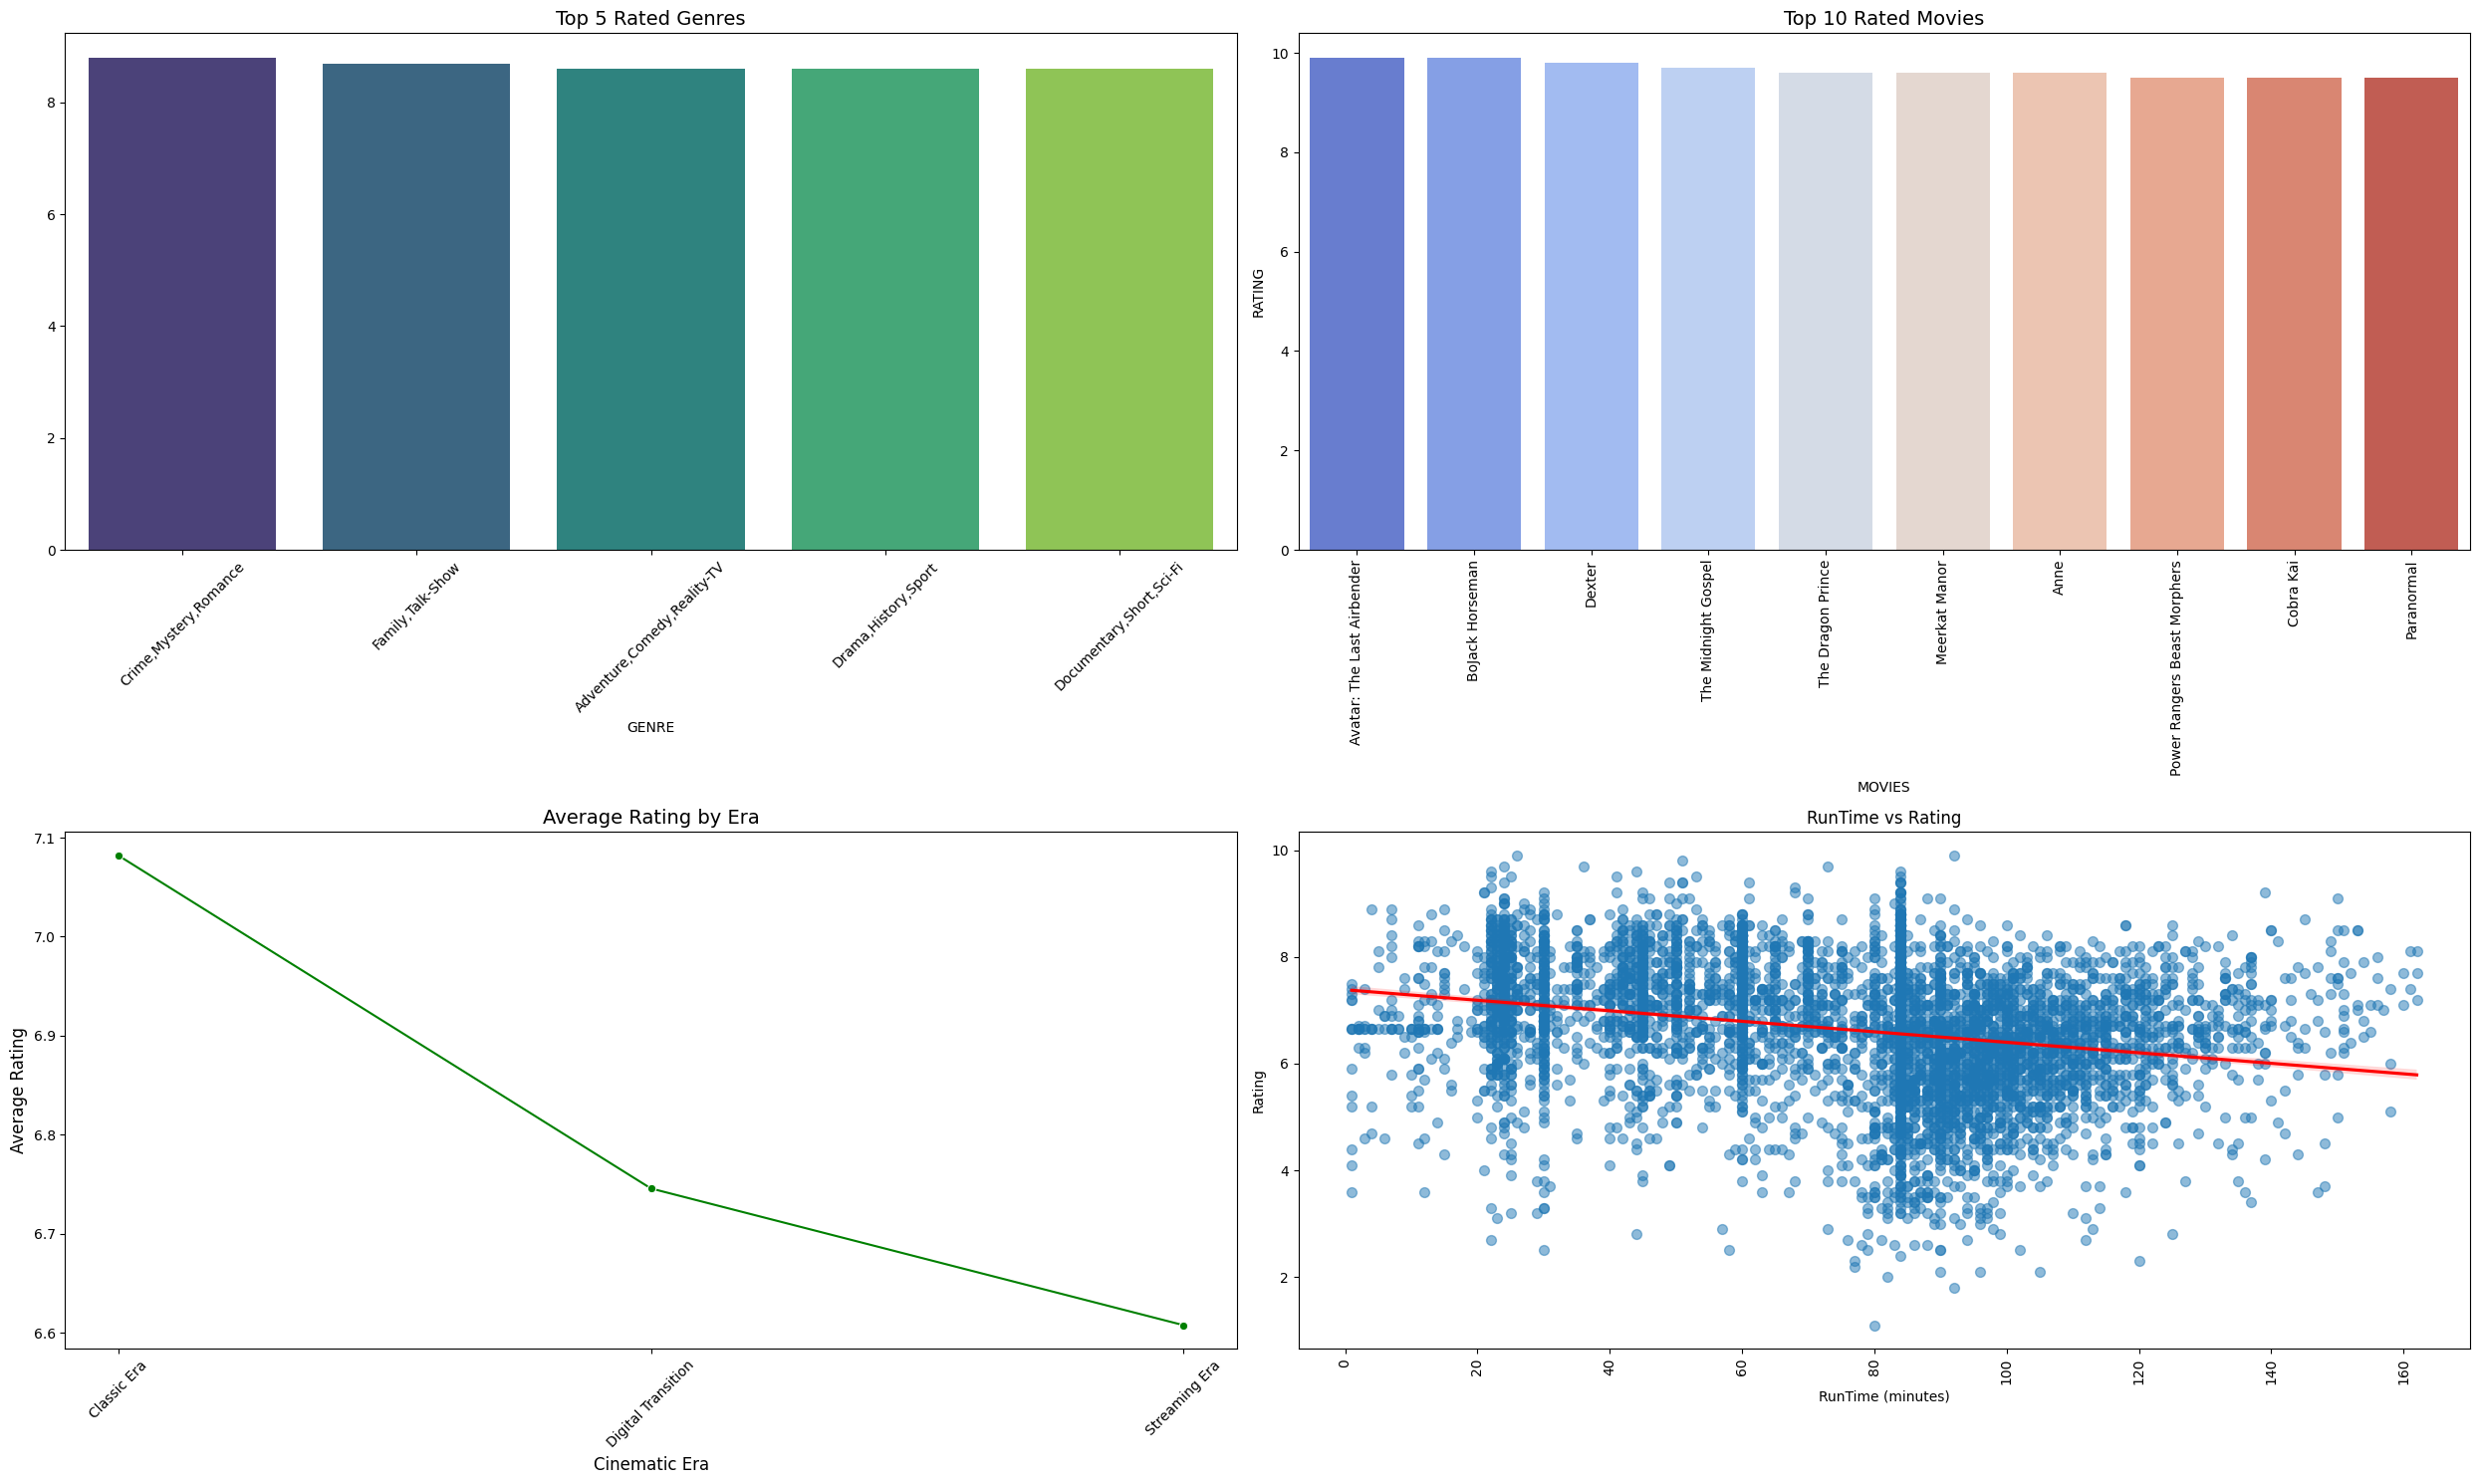

In [ ]:
bins = [1930, 1999, 2009, 2025]
labels = ["Classic Era", "Digital Transition", "Streaming Era"]

# Assign movies to the defined eras
filtered_movies['ERA'] = pd.cut(filtered_movies['YEAR'], bins=bins, labels=labels, right=True)

top_5_genres = filtered_movies.groupby('GENRE')['RATING'].mean().sort_values(ascending=False).head(5)
top_rated_movies = filtered_movies.groupby("GENRE", group_keys=False).apply(lambda x: x.nlargest(1, "RATING")).reset_index(drop=True)
top_10_rated_movies = top_rated_movies.nlargest(10, "RATING")
average_rating_by_era = filtered_movies.groupby('ERA')['RATING'].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(25, 15))

# **Plot 1: Top 5 Rated Genres**
sns.barplot(x=top_5_genres.index, y=top_5_genres.values, hue=top_5_genres.index, palette='viridis', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Top 5 Rated Genres', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)

# **Plot 2: Top 10 Rated Movies Across Genres**
sns.barplot(x="MOVIES", y="RATING", hue="MOVIES", data=top_10_rated_movies, palette='coolwarm', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Top 10 Rated Movies', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot the Lineplot of Average Ratings of every decade
sns.lineplot(x='ERA', y='RATING', data=average_rating_by_era, marker='o', color='green', ax=axes[1, 0])
axes[1, 0].set_title("Average Rating by Era", fontsize=14)
axes[1, 0].set_xlabel("Cinematic Era", fontsize=12)
axes[1, 0].set_ylabel("Average Rating", fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

sns.regplot(x='RunTime', y='RATING', data= filtered_movies, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'})
axes[1, 1].set_title('RunTime vs Rating')
axes[1, 1].set_xlabel("RunTime (minutes)")
axes[1, 1].set_ylabel("Rating")
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
warnings.filterwarnings("ignore")


**Observations**

*   Bojack Horeseman, Dexter, Avatar are top 3 rated movies
*   Classic Era movies🎥 are popular
*   Shorter the Movie, Better the Rating








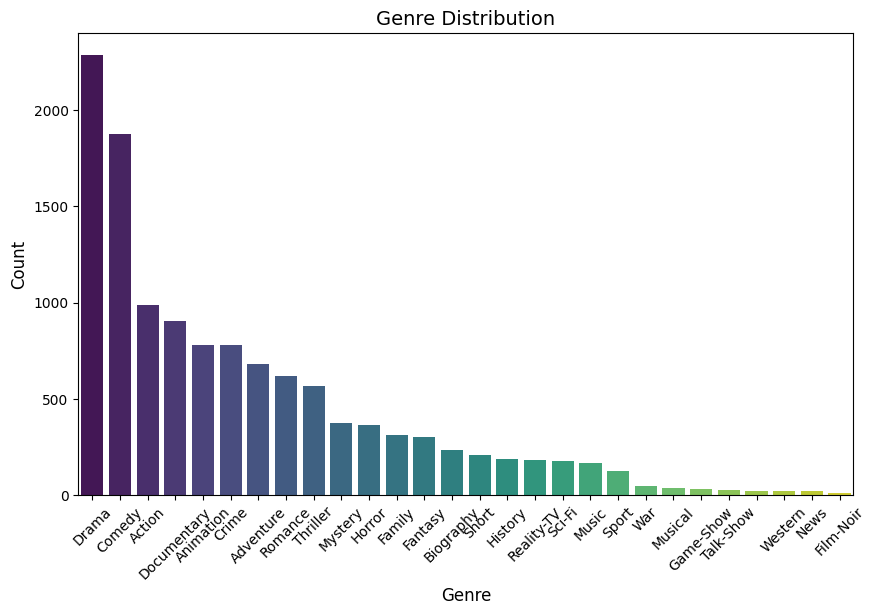

In [ ]:
# Count the frequency of each genre
genre_counts = filtered_movies['GENRE'].str.split(',').explode().value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()

Observations



*   Lowest Genre movies is Film-Noir (only 12 movies)
*   Highest Genre movies is Drama (2090 movies), followed by Comedy



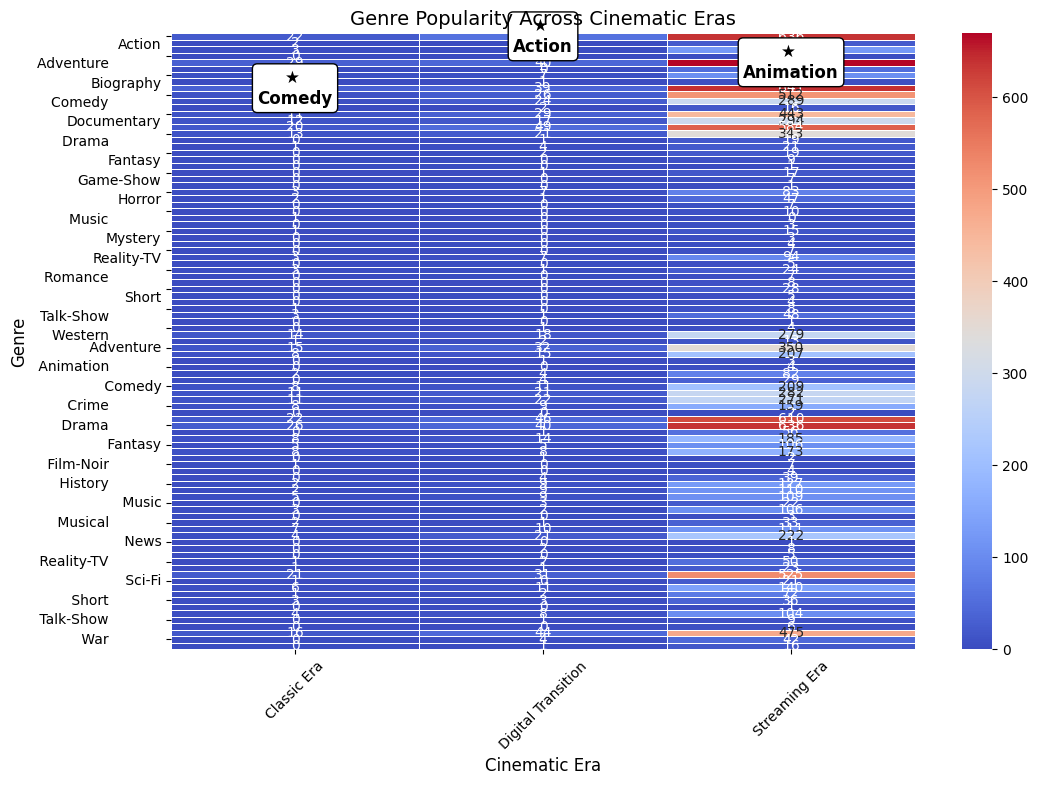

In [ ]:
# Define custom year bins and labels for categories
bins = [1930, 1999, 2009, 2025]
labels = ["Classic Era", "Digital Transition", "Streaming Era"]

# Assign movies to the defined eras
filtered_movies['ERA'] = pd.cut(filtered_movies['YEAR'], bins=bins, labels=labels, right=True)

# Explode the GENRE column for analysis
filtered_movies_exploded = filtered_movies.assign(GENRE=movies_new['GENRE'].str.split(',')).explode('GENRE')

# Group by new 'ERA' categories and GENRE
genre_per_era = filtered_movies_exploded.groupby(['ERA', 'GENRE']).size().reset_index(name='MOVIE_COUNT')

# Find the most popular genre per era
top_genres_per_era = genre_per_era.loc[genre_per_era.groupby("ERA")["MOVIE_COUNT"].idxmax()]

# Create a pivot table for the heatmap
pivot_data = genre_per_era.pivot(index='GENRE', columns='ERA', values='MOVIE_COUNT').fillna(0)

# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt=".0f", linewidths=0.5)

# Annotate the heatmap with the most popular genre for each era
for index, row in top_genres_per_era.iterrows():
    era = row['ERA']
    genre = row['GENRE']
    x_pos = list(pivot_data.columns).index(era)
    y_pos = list(pivot_data.index).index(genre)

    ax.text(x_pos + 0.5, y_pos + 0.5, f"★ {genre}", color='black', fontsize=12, weight='bold',
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Titles and labels
plt.title("Genre Popularity Across Cinematic Eras", fontsize=14)
plt.xlabel("Cinematic Era", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.xticks(rotation=45)
plt.show()


**Observations**

*   Classic Era 🎥 has the most popular rated movies with Comedy Genre
*   Streaming Era: technology transitioned rapidly making **Animation** movies popular




In [ ]:
filtered_movies

MOVIES    YEAR  \
0                                       BoJack Horseman  2014.0   
1                            Avatar: The Last Airbender  2005.0   
2                                                Dexter  2006.0   
3                                   The Midnight Gospel  2020.0   
4                    She-Ra and the Princesses of Power  2018.0   
...                                                 ...     ...   
5909                                        As We Sleep  2002.0   
5910                                       My First Day  2001.0   
5911                                The House of Spirit  2001.0   
5912  Graffiti Verité 3: A Voyage Into the Iconograp...  2000.0   
5913                                     Magic 4 Morons  2000.0   

                           GENRE    RATING  \
0         Animation,Comedy,Drama  9.900000   
1     Animation,Action,Adventure  9.900000   
2            Crime,Drama,Mystery  9.800000   
3     Animation,Adventure,Comedy  9.700000   
4     Animation,Action,Adventure  9.700000   
...                          ...       ...   
5909                              6.643458   
5910                Short,Family  6.643458   
5911           Documentary,Short  6.643458   
5912           Documentary,Music  6.643458   
5913                      Family  6.643458   

                                               ONE-LINE  VOTES  RunTime  \
0           BoJack reconnects with faces from his past.  265.0     26.0   
1     Aang's moment of truth arrives. Can he defeat ...  265.0     92.0   
2     Dexter and Arthur find themselves on a collisi...  265.0     51.0   
3     Clancy joins his mother on an emotional journe...  265.0     36.0   
4     Adora surrenders herself to Horde Prime, hopin...  265.0     24.0   
...                                                 ...    ...      ...   
5909                                         Add a Plot  265.0     84.0   
5910  Buddy Bear is afraid of attending his first da...  265.0     30.0   
5911  Shao Fang and her late husband, Sheng Pao, wer...  265.0     43.0   
5912  This experimental musical opus probes the soci...  265.0     54.0   
5913  Magic 4 Morons teaches the viewer 10 amazing m...  265.0     60.0   

      is_duplicate                  Director  \
0            False         Amy Winfrey Stars   
1            False  Joaquim Dos Santos Stars   
2            False         Steve Shill Stars   
3            False                             
4            False                             
...            ...                       ...   
5909         False        Elizabeth Mcdonald   
5910         False                    John P   
5911         False              Weimin Zhang   
5912         False           Bob Bryan Stars   
5913         False        Rick Pamplin Stars   

                                                  Stars  \
0         Will Arnett, Amy Sedaris, Alison Brie, Paul F   
1     Zach Tyler, Mae Whitman, Jack De Sena, Michael...   
2                                             Michael C   
3     Joey Diaz, Deneen Fendig, Phil Hendrie, Steve ...   
4     Aimee Carrero, Karen Fukuhara, AJ Michalka, Ma...   
...                                                 ...   
5909                                                      
5910  Arturo Gil, Michael Munoz, Farah Bunch, Erin E...   
5911                                                      
5912                         Bruin, Chaz, Man One, Mare   
5913  Eric Miles, Tim Scarbrough, Kristin Stone, Mic...   

                                      cleaned_one_liner                 ERA  
0                          bojack reconnects faces past       Streaming Era  
1     aangs moment truth arrives defeat ozai phoenix...  Digital Transition  
2     dexter arthur find collision course debra unea...  Digital Transition  
3     clancy joins mother emotional journey wondrous...       Streaming Era  
4     adora surrenders horde prime hoping buy time e...       Streaming Era  
...                                 

<Figure size 1500x2000 with 0 Axes>

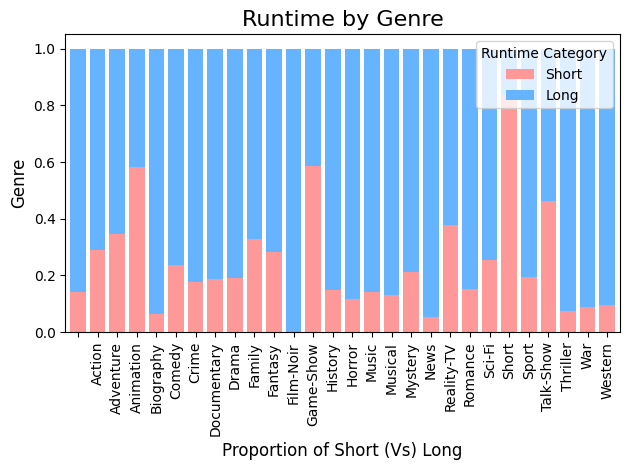

In [ ]:
# Create the 'RUNTIME_CATEGORY' column
filtered_movies['RUNTIME_CATEGORY'] = filtered_movies['RunTime'].apply(lambda x: 'Short' if x < 50 else 'Long')

# Explode the GENRE column for analysis
filtered_movies_exploded = filtered_movies.assign(GENRE=filtered_movies['GENRE'].str.split(',')).explode('GENRE')
runtime_genre_counts = filtered_movies_exploded.groupby(['GENRE', 'RUNTIME_CATEGORY']).size().unstack(fill_value=0)

runtime_genre_counts['Total'] = runtime_genre_counts.sum(axis=1)
runtime_genre_proportions = runtime_genre_counts.div(runtime_genre_counts['Total'], axis=0)

# horizontal bar plot
plt.figure(figsize=(15, 20))
runtime_genre_proportions[['Short', 'Long']].plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], width=0.8)

plt.title('Runtime by Genre', fontsize=16)
plt.xlabel('Proportion of Short (Vs) Long', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.subplots_adjust(left=0.2)  # Adjust to make room for y-labels

# Add a legend
plt.legend(title='Runtime Category', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


**Observation**
1. There are certain genres like (Adventure, Film-Noir, Short, Talkshow) that have more short run times movies than Long. This information could be helpful in genre predictions

**Most Common Genres by Director**

In [ ]:
exploded_genres = filtered_movies.explode('GENRE')
# Step 2: Group by director and count occurrences of each genre
genre_counts = exploded_genres.groupby(['Director', 'GENRE']).size().unstack(fill_value=0)
genre_counts['Total Movies'] = genre_counts.sum(axis=1)
# Most common genre for each director
most_common_genre = genre_counts.idxmax(axis=1)

summary_df = pd.DataFrame({
    'Total Movies': genre_counts['Total Movies'],
    'Most Common Genre': most_common_genre
})
styled_summary_df = summary_df.style.background_gradient(cmap='viridis', subset=['Total Movies'])

styled_summary_df


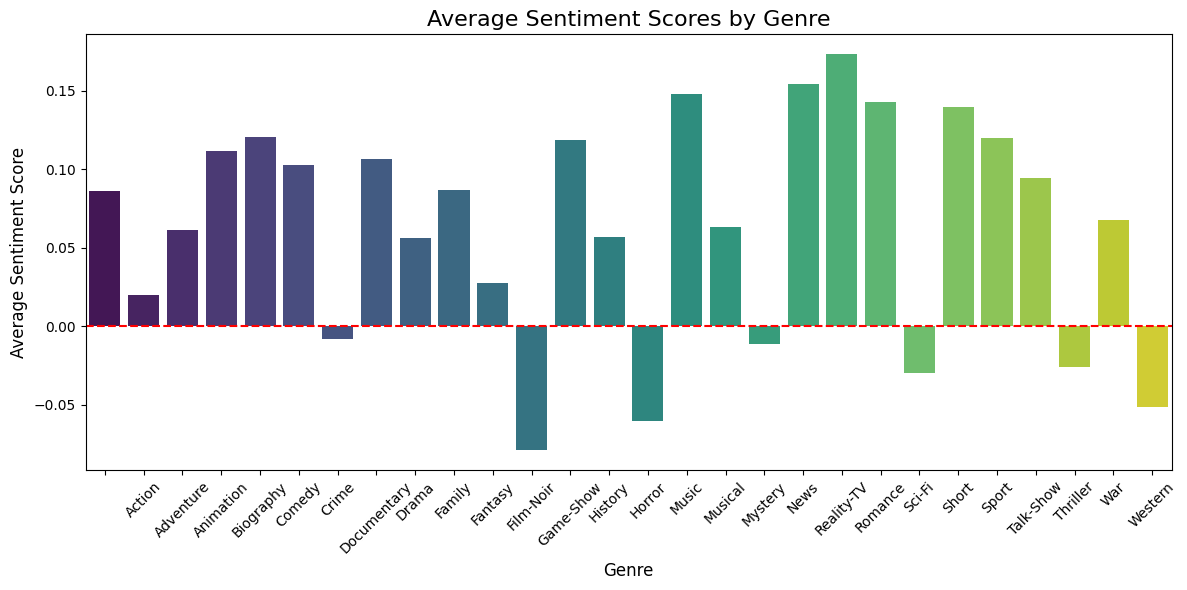

          GENRE  one-liner-sentiment
0                           0.086190
1        Action             0.019783
2     Adventure             0.061065
3     Animation             0.111746
4     Biography             0.120870
5        Comedy             0.102574
6         Crime            -0.007864
7   Documentary             0.106803
8         Drama             0.056516
9        Family             0.086925
10      Fantasy             0.027349
11    Film-Noir            -0.078959
12    Game-Show             0.118871
13      History             0.056707
14       Horror            -0.060218
15        Music             0.147977
16      Musical             0.062986
17      Mystery            -0.011330
18         News             0.154629
19   Reality-TV             0.173365
20      Romance             0.142885
21       Sci-Fi            -0.029621
22        Short             0.139819
23        Sport             0.119816
24    Talk-Show             0.094444
25     Thriller            -0.025774
2

In [ ]:
# Function to get sentiment score
def get_sentiment_score(one_liner):
    return TextBlob(one_liner).sentiment.polarity

filtered_movies['one-liner-sentiment'] = filtered_movies['ONE-LINE'].apply(get_sentiment_score)
filtered_movies_exploded = filtered_movies_exploded.merge(filtered_movies[['MOVIES', 'one-liner-sentiment']], on='MOVIES', how='left')
sentiment_genre_scores = filtered_movies_exploded.groupby('GENRE')['one-liner-sentiment'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='GENRE', y='one-liner-sentiment', data=sentiment_genre_scores, palette='viridis')
plt.title('Average Sentiment Scores by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()
# Display average sentiment scores for each genre
print(sentiment_genre_scores)

**Observations**

*   Crime, Horror, Thriller, Western and Film-Noir have negative sentiment scores.. this information can be later used to predict genres



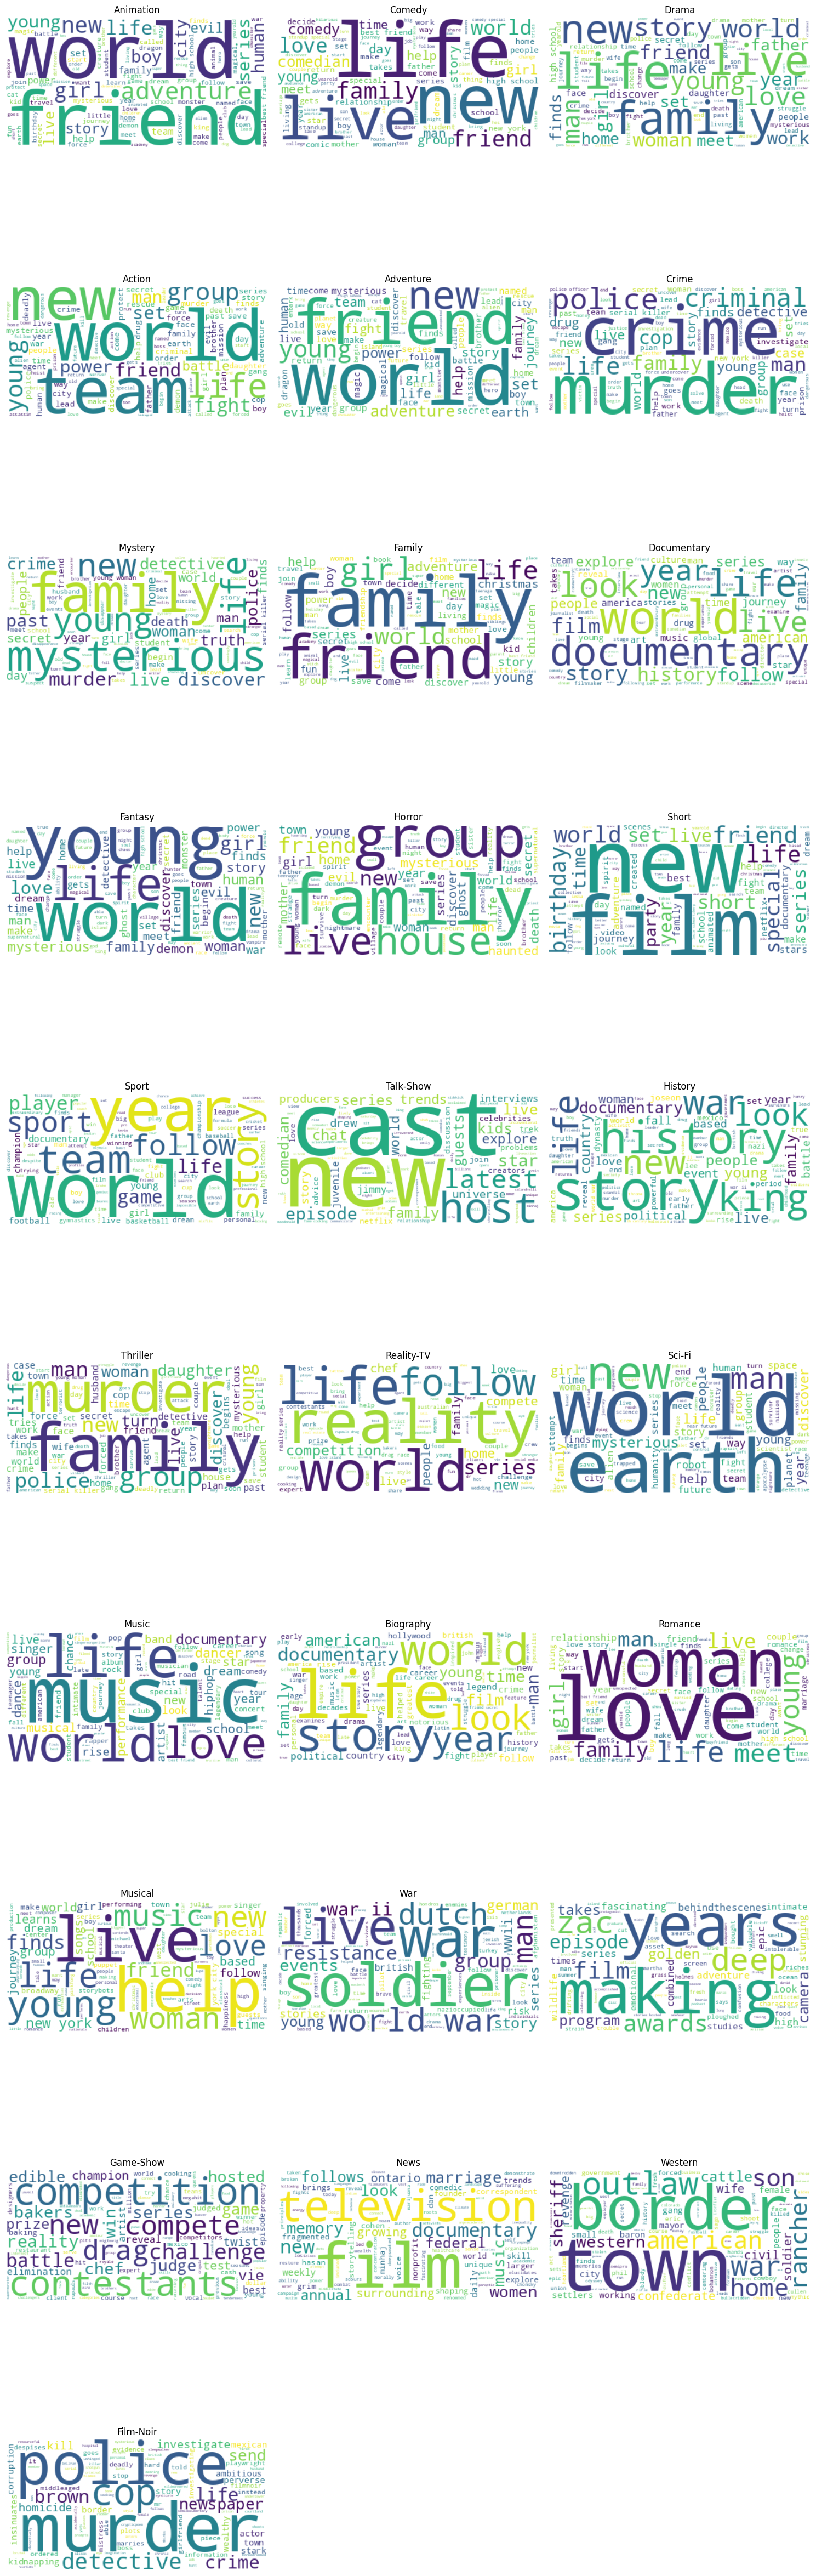

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

# Create a word cloud for each genre
genres = filtered_movies_exploded['GENRE'].unique()
num_genres = len(genres)
num_rows = (num_genres + 2) // 3
plt.figure(figsize=(15, num_rows * 5))

all_one_liners = ' '.join(filtered_movies_exploded['cleaned_one_liner'])
word_counts = Counter(all_one_liners.lower().split())
custom_words_to_remove = {'summary', 'full', 'see', 'and', 'to', 'is', 'in', 'for', 'that', 'of'}
words_to_remove = set(stop_words).union(custom_words_to_remove)

for i, genre in enumerate(genres):
    plt.subplot(num_rows, 3, i + 1)
    # Get unique one-liners for the genre
    genre_one_liners = filtered_movies_exploded[filtered_movies_exploded['GENRE'] == genre]['cleaned_one_liner'].unique()
    genre_one_liners_joined = ' '.join(genre_one_liners)
    genre_one_liners_filtered = ' '.join(word for word in genre_one_liners_joined.split() if word.lower() not in words_to_remove)

    # Generate the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white', colormap='viridis', max_words=100).generate(genre_one_liners_filtered)

    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(genre)

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

top_keywords_by_genre = {}

for genre in genres:
    # Extract unique one-liners per genre
    genre_one_liners = filtered_movies_exploded[filtered_movies_exploded['GENRE'] == genre]['cleaned_one_liner'].unique()
    genre_one_liners_joined = ' '.join(genre_one_liners)

    # Remove stopwords
    genre_one_liners_filtered = ' '.join(word for word in genre_one_liners_joined.split() if word.lower() not in words_to_remove)

    # Count word occurrences
    genre_word_counts = Counter(genre_one_liners_filtered.lower().split())

    # Get Top-N keywords
    top_n_keywords = genre_word_counts.most_common(10)  # Adjust as needed
    top_keywords_by_genre[genre] = top_n_keywords

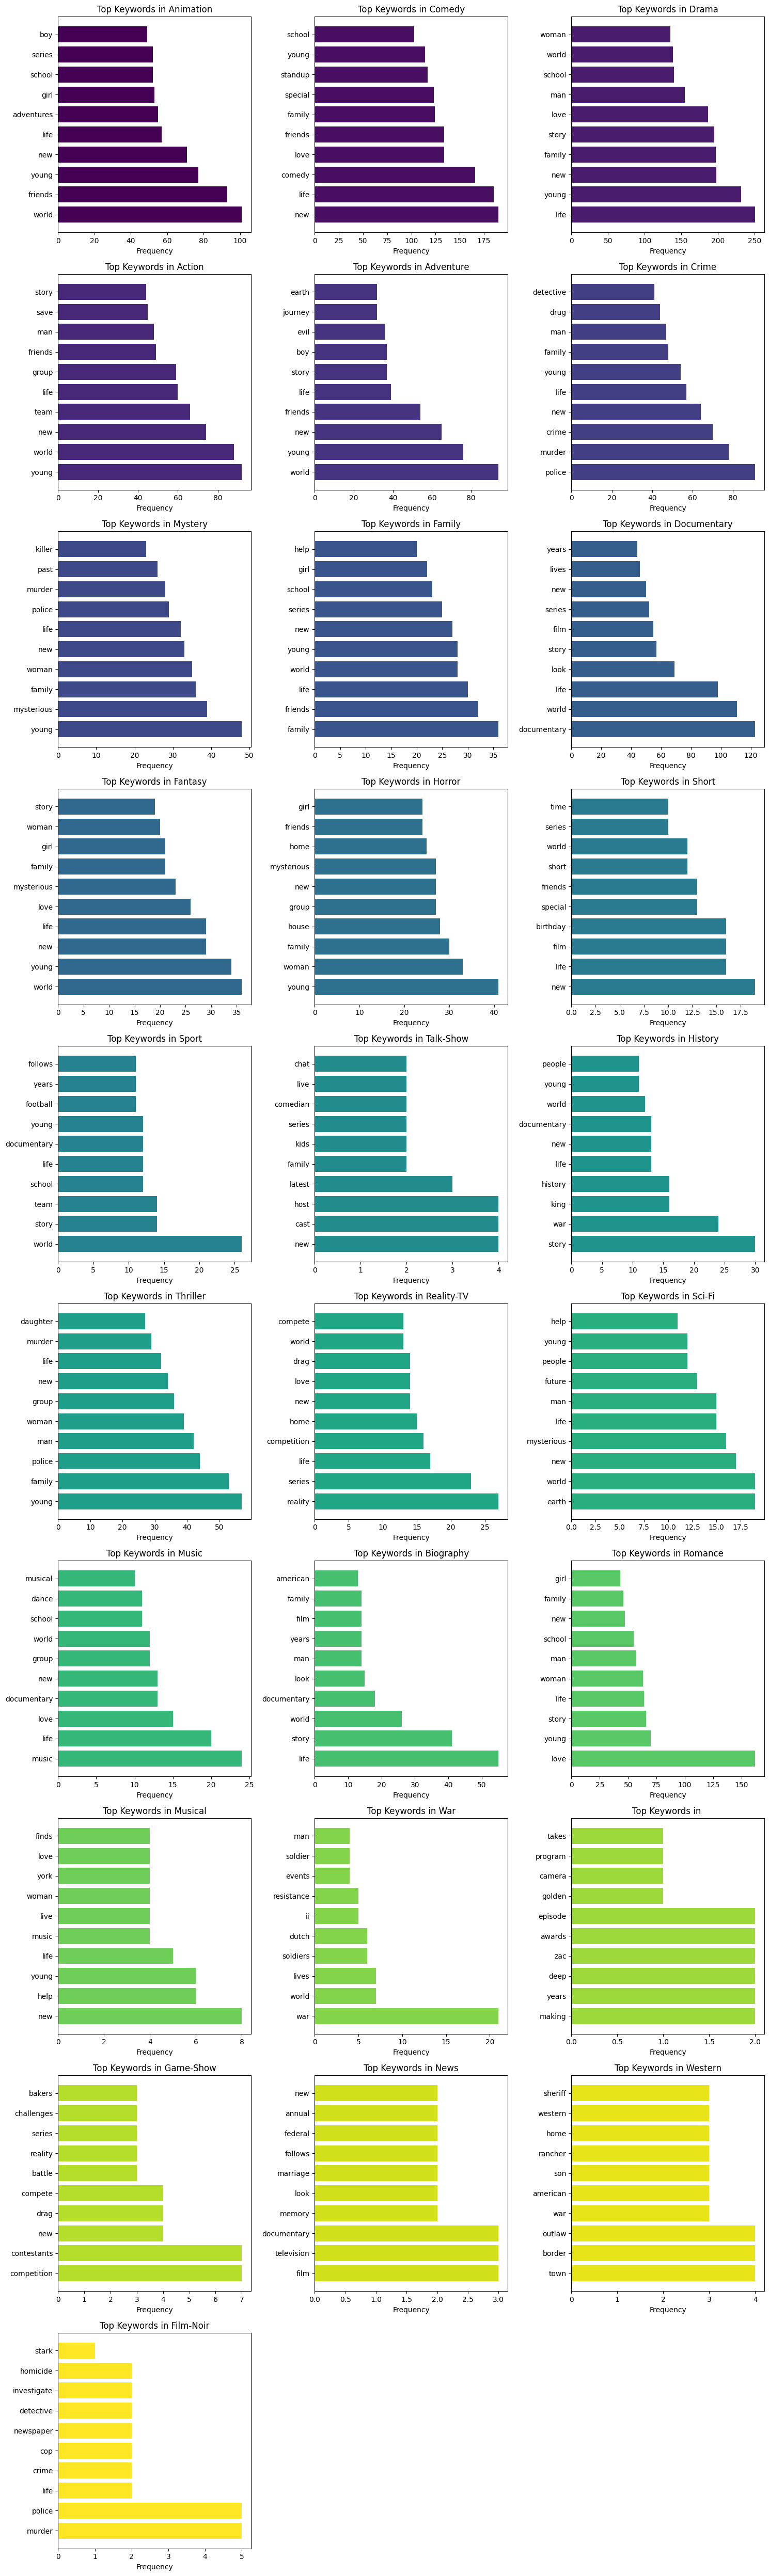

In [ ]:
num_genres = len(top_keywords_by_genre)
num_rows = (num_genres + 2) // 3  # Ensure enough rows
plt.figure(figsize=(15, num_rows * 5))

colors = plt.cm.viridis(np.linspace(0, 1, num_genres))

for i, (genre, keywords) in enumerate(top_keywords_by_genre.items()):
    plt.subplot(num_rows, 3, i + 1)
    keywords, counts = zip(*keywords)

    plt.barh(keywords, counts, color=colors[i])
    plt.xlabel('Frequency')
    plt.title(f'Top Keywords in {genre}')

plt.tight_layout()
plt.show()


**Observations**

*  Each genre has popular keywords that represent genre using that information can be very helpful in genre prediction

*   Crime Genre : detective, drug , live, crime, murder.
*   Sport Genre : follows, year, football, team





In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from collections import Counter

filtered_movies['GENRE'] = filtered_movies['GENRE'].str.split(',')  # Ensure GENRE is a list of genres
genres_list = filtered_movies['GENRE'].tolist()
mlb = MultiLabelBinarizer()

# Fit and transform the list of genres
genre_one_hot = mlb.fit_transform(genres_list)

# Create a DataFrame with the binary-encoded genres
genre_df = pd.DataFrame(genre_one_hot, columns=mlb.classes_)


# Step 1: Count keyword occurrences for each genre
keyword_counts = Counter()
for genre, keywords in top_keywords_by_genre.items():
    for keyword, count in keywords:
        keyword_counts[keyword] += count

keyword_counts = Counter()
for genre, keywords in top_keywords_by_genre.items():
    for keyword, count in keywords:
        keyword_counts[keyword] += count

# Create a DataFrame for keyword occurrences
keyword_counts_df = pd.DataFrame(0, index=filtered_movies_exploded['MOVIES'].unique(), columns=keyword_counts.keys())

# Populate the keyword counts DataFrame
for genre in top_keywords_by_genre:

    genre_movies = filtered_movies_exploded[filtered_movies_exploded['GENRE'] == genre]['MOVIES'].unique()
    # Get the top keywords for this genre
    top_keywords = [keyword for keyword, count in top_keywords_by_genre[genre]]
    keyword_counts_df.loc[genre_movies, top_keywords] = 1  # Set 1 for presence

keyword_counts_df = keyword_counts_df.reset_index()  # Converts index into a column
keyword_counts_df.rename(columns={'index': 'MOVIES'}, inplace=True)  # Rename to match other datasets

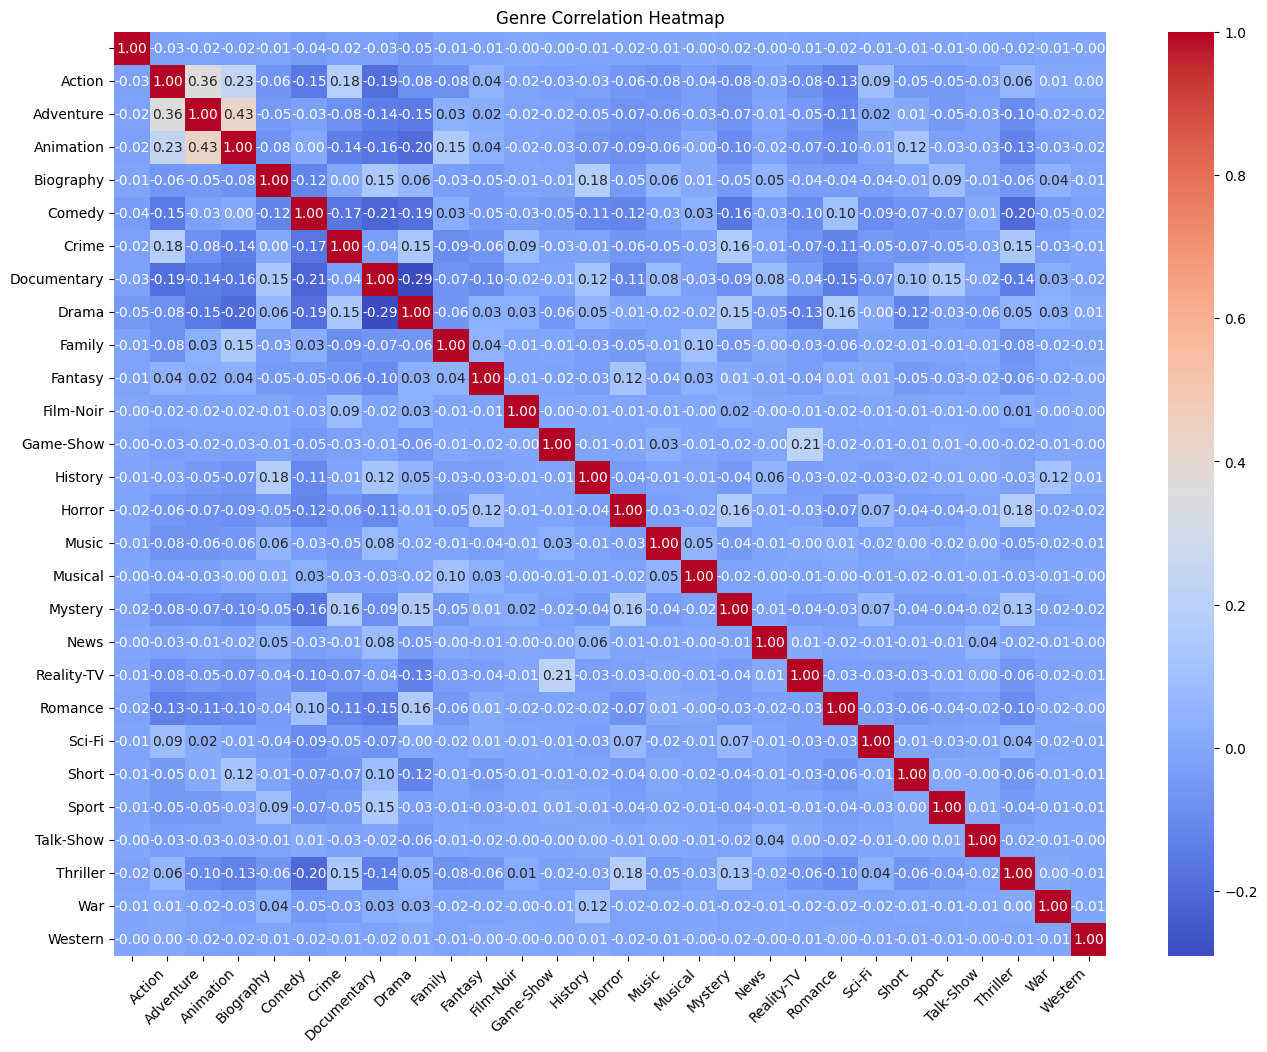

In [ ]:

genre_correlation = genre_df.corr()
# Step 4: Visualize with a Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(genre_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Genre Correlation Heatmap")
plt.show()

**Observations**

*   Adventure and Animation has a correlation of 0.43 which typically means these genres are high likely to be together in a movie or in general strong correlation  
*   Romance and War has a negative correlation of -0.02 which shows that these genres can never be together in a movie







TOP Genre Combinations


* To check if a movie belongs to a certain Genre, what are the other Genres it might fall under


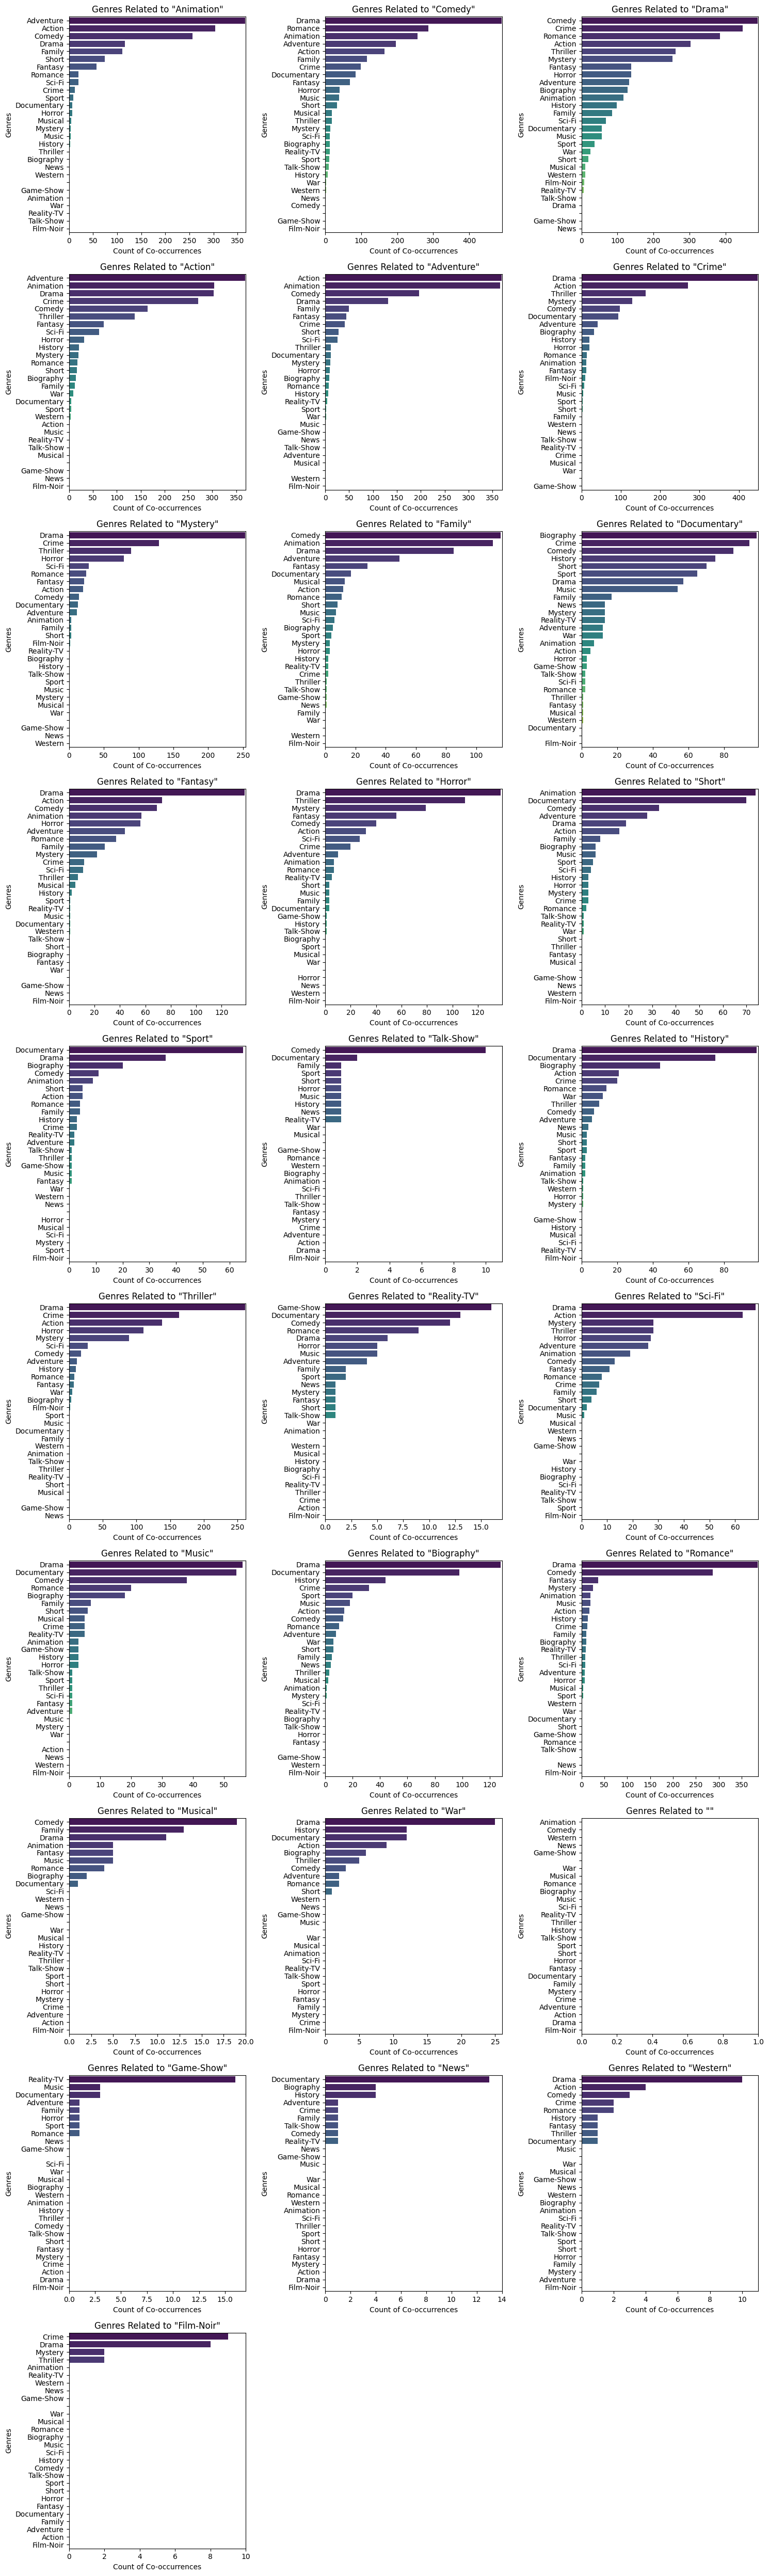

In [ ]:
exploded_genres = filtered_movies.explode('GENRE')
genre_combinations = pd.DataFrame(0, index=exploded_genres['GENRE'].unique(), columns=exploded_genres['GENRE'].unique())

for genre in genre_combinations.index:
    # Get movies that contain this genre
    movies_with_genre = exploded_genres[exploded_genres['GENRE'] == genre]

    # Get all genres for these movies
    other_genres = exploded_genres[exploded_genres['MOVIES'].isin(movies_with_genre['MOVIES'])]

    # Count occurrences of other genres
    for other_genre in other_genres['GENRE'].unique():
        if other_genre != genre:  # Exclude self
            genre_combinations.at[genre, other_genre] = other_genres[other_genres['GENRE'] == other_genre].shape[0]

# Step 3: Plotting for all genres
num_genres = genre_combinations.shape[0]
num_rows = (num_genres + 2) // 3  # Calculate number of rows needed
plt.figure(figsize=(15, num_rows * 5))  # Adjust figure height based on number of genres

for i, genre in enumerate(genre_combinations.index):
    related_genres = genre_combinations.loc[genre].sort_values(ascending=False)

    # Create a subplot for each genre
    plt.subplot(num_rows, 3, i + 1)
    sns.barplot(x=related_genres.values, y=related_genres.index, palette='viridis')
    plt.title(f'Genres Related to "{genre}"')
    plt.xlabel('Count of Co-occurrences')
    plt.ylabel('Genres')
    plt.xlim(0, related_genres.max() + 1)  # Adjust xlim for better visualization

plt.tight_layout()
plt.show()

In [ ]:
genre_df['MOVIES'] = filtered_movies['MOVIES']

# Ensure no unnecessary index
filtered_movies = filtered_movies.reset_index(drop=True)
genre_df = genre_df.reset_index()
keyword_counts_df = keyword_counts_df.reset_index()


In [ ]:
genre_df.drop(columns=['index'], inplace=True)
keyword_counts_df.drop(columns=['index'], inplace=True)

In [ ]:
keyword_counts_df['MOVIES']

0                                         BoJack Horseman
1                              Avatar: The Last Airbender
2                                                  Dexter
3                                     The Midnight Gospel
4                      She-Ra and the Princesses of Power
                              ...                        
5812                                          As We Sleep
5813                                         My First Day
5814                                  The House of Spirit
5815    Graffiti Verité 3: A Voyage Into the Iconograp...
5816                                       Magic 4 Morons
Name: MOVIES, Length: 5817, dtype: object

In [ ]:
final_df = filtered_movies.merge(genre_df, on="MOVIES", how="left")
final_df = final_df.merge(keyword_counts_df, on="MOVIES", how="left")

In [ ]:
from sklearn.preprocessing import LabelEncoder
era_encoder = LabelEncoder()
runtime_encoder = LabelEncoder()
final_df['ERA'] = era_encoder.fit_transform(final_df['ERA'])
final_df['RUNTIME_CATEGORY'] = runtime_encoder.fit_transform(final_df['RUNTIME_CATEGORY'])

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5817 entries, 0 to 5816
Columns: 146 entries, MOVIES to stark
dtypes: bool(1), float64(33), int64(106), object(6)
memory usage: 6.4+ MB


# Task 2

1. Which features from the dataset would you prioritize initially for building this model, and why?


*         ERA (Release Year): The time period of a movie can significantly influence its genre, as different genres tend to be more popular in specific eras. For instance, horror movies may have gained traction during particular decades, affecting audience preferences and trends.

      Runtime Category: The duration of a movie often correlates with its genre, as certain genres, such as animated films or family movies, may typically have shorter runtimes compared to epics or dramas. Categorizing runtime into ranges helps the model identify genre patterns based on movie length.

      One-Liner Movie Sentiment: The sentiment extracted from a one-liner description provides valuable insights into the emotional tone of a movie, which is frequently associated with specific genres. For example, positive sentiments may correlate with comedies or feel-good films, while negative sentiments might align with dramas or thrillers.

      One-Hot Encoded Genres: One-hot encoding allows the model to treat genres as binary features (0 or 1), which is crucial for multi-label classification. This approach enables the model to effectively learn which genres are present in each movie, accommodating the fact that movies can belong to multiple genres.

      Popular Keywords of Genre Information: Keywords associated with genres enhance the model's understanding of a movie's content. Terms like "spaceship," "sword," or "romance" signal specific genres and aid the model in identifying genre associations based on textual features, contributing to more accurate predictions.




2. Since movies can belong to multiple genres, explain your strategy for handling multi-label classification?

*     To handle multi-label classification for movie genres, **I utilized the binary relevance approach**, treating each genre as an independent binary classification problem. I implemented the MultiOutputClassifier, which effectively applies this strategy by creating separate models for each genre, allowing the model to learn to predict multiple genres associated with a single movie accurately. This approach ensures that the presence or absence of each genre is evaluated independently, accommodating the fact that movies can belong to multiple genres.







3. Outline your approach for model training and validation (e.g., cross-validation or time-based splits).



*   For model training and validation, I used k-fold cross-validation instead of a time-based split.



*   **K-fold cross-validation** ensures that the model is trained and evaluated on different subsets of data, making it more robust and less dependent on a specific train-test split. Since movie genres are not inherently time-dependent (e.g., a 2020 action movie is not fundamentally different from a 1990 action movie in terms of genre classification), it makes sense to randomly shuffle and split the data for training and validation. A time-based split might be useful when there is a temporal relationship in the data, such as in stock price prediction or sales forecasting, where past trends influence future outcomes. However, in genre prediction, past movies do not directly determine future genres in a sequential manner. So I used **k-fold cross-validation**






4. Discuss how you would measure the effectiveness of your genre prediction model in a real-world scenario.



*   To measure the effectiveness of the genre prediction model in a real-world scenario, I would use a combination of quantitative metrics and practical validation methods:

    1. Evaluation Metrics
    Since this is a multi-label classification problem, traditional accuracy isn’t enough. Instead, I would focus on:

      Hamming Loss – Measures the fraction of incorrect labels, accounting for both false positives and false negatives.
      F1-Score (Macro & Weighted) – Balances precision and recall to ensure both rare and common genres are correctly classified.
    Precision & Recall – Precision ensures the model isn't over-predicting genres, while recall ensures it captures all relevant genres.
    2. Real-World Validation
    User Feedback & Surveys – Validate predictions with human reviewers or movie experts to check if the assigned genres make sense.
    Comparison with IMDb/Rotten Tomatoes Genres – Cross-check predictions with well-established movie databases.

Feature Selection and Modelling

In [ ]:
final_df = final_df.drop(columns=['YEAR', 'RATING', 'VOTES', 'ONE-LINE','cleaned_one_liner','RunTime', 'is_duplicate', 'Director', 'Stars'])

In [ ]:
final_df['one-liner-sentiment']

0      -0.250000
1       0.233333
2      -0.750000
3       0.000000
4       0.000000
          ...   
5812    0.000000
5813    0.069318
5814   -0.050000
5815    0.056667
5816    0.142045
Name: one-liner-sentiment, Length: 5817, dtype: float64




*  X (Features/Input Variables) → Training data
*  y (Target/Labels) → Multi-label target (movie genres)

  *   So:
  X contains features like ERA, runtime category, sentiment, keywords, etc.
  y contains the one-hot encoded genres, where each column represents a genre (1 = present, 0 = absent).

In [ ]:
X = final_df.drop(columns=["MOVIES", "GENRE"])  # Features
y = genre_df.drop(columns=["MOVIES"])  # Multi-label genre targets

In [ ]:
final_df.head()

MOVIES                           GENRE  ERA  \
0                     BoJack Horseman      [Animation, Comedy, Drama]    2   
1          Avatar: The Last Airbender  [Animation, Action, Adventure]    1   
2                              Dexter         [Crime, Drama, Mystery]    1   
3                 The Midnight Gospel  [Animation, Adventure, Comedy]    2   
4  She-Ra and the Princesses of Power  [Animation, Action, Adventure]    2   

   RUNTIME_CATEGORY  one-liner-sentiment       Action  Adventure  Animation  \
0                 1            -0.250000  0.0     0.0        0.0        1.0   
1                 0             0.233333  0.0     1.0        1.0        1.0   
2                 0            -0.750000  0.0     0.0        0.0        0.0   
3                 1             0.000000  0.0     0.0        1.0        1.0   
4                 1             0.000000  0.0     1.0        1.0        1.0   

   Biography  ...  outlaw  son  rancher  western  sheriff  cop  newspaper  \
0        0.0  ...       0    0        0        0        0    0          0   
1        0.0  ...       0    0        0        0        0    0          0   
2        0.0  ...       0    0        0        0        0    0          0   
3        0.0  ...       0    0        0        0        0    0          0   
4        0.0  ...       0    0        0        0        0    0          0   

   investigate  homicide  stark  
0            0         0      0  
1            0         0      0  
2            0         0      0  
3            0         0      0  
4            0         0      0  

[5 rows x 137 columns]

In [ ]:
X = final_df.drop(columns=["one-liner-sentiment", "RUNTIME_CATEGORY", "ERA"])

In [ ]:
X = X.drop(columns=['index', 'index_x'], errors='ignore')
y = y.drop(columns=['index', 'index_x'], errors='ignore')

In [ ]:
X = X.drop(columns=['ERA', 'one-liner-sentiment', 'RUNTIME_CATEGORY', ], errors='ignore')


In [ ]:
X = X.drop(columns=["MOVIES", "GENRE"])  # Features


Action  Adventure  Animation  Biography  Comedy  Crime  \
0     0.0     0.0        0.0        1.0        0.0     1.0    0.0   
1     0.0     1.0        1.0        1.0        0.0     0.0    0.0   
2     0.0     0.0        0.0        0.0        0.0     0.0    1.0   
3     0.0     0.0        1.0        1.0        0.0     1.0    0.0   
4     0.0     1.0        1.0        1.0        0.0     0.0    0.0   
...   ...     ...        ...        ...        ...     ...    ...   
5812  NaN     NaN        NaN        NaN        NaN     NaN    NaN   
5813  NaN     NaN        NaN        NaN        NaN     NaN    NaN   
5814  NaN     NaN        NaN        NaN        NaN     NaN    NaN   
5815  NaN     NaN        NaN        NaN        NaN     NaN    NaN   
5816  NaN     NaN        NaN        NaN        NaN     NaN    NaN   

      Documentary  Drama  Family  ...  outlaw  son  rancher  western  sheriff  \
0             0.0    1.0     0.0  ...       0    0        0        0        0   
1             0.0    0.0     0.0  ...       0    0        0        0        0   
2             0.0    1.0     0.0  ...       0    0        0        0        0   
3             0.0    0.0     0.0  ...       0    0        0        0        0   
4             0.0    0.0     0.0  ...       0    0        0        0        0   
...           ...    ...     ...  ...     ...  ...      ...      ...      ...   
5812          NaN    NaN     NaN  ...       0    0        0        0        0   
5813          NaN    NaN     NaN  ...       0    0        0        0        0   
5814          NaN    NaN     NaN  ...       0    0        0        0        0   
5815          NaN    NaN     NaN  ...       0    0        0        0        0   
5816          NaN    NaN     NaN  ...       0    0        0        0        0   

      cop  newspaper  investigate  homicide  stark  
0       0          0            0         0      0  
1       0          0            0         0      0  
2       0          0            0         0      0  
3       0          0            0         0      0  
4       0          0            0         0      0  
...   ...        ...          ...       ...    ...  
5812    0          0            0         0      0  
5813    0          0            0         0      0  
5814    0          0            0         0      0  
5815    0          0            0         0      0  
5816    0          0            0         0      0  

[5817 rows x 132 columns]

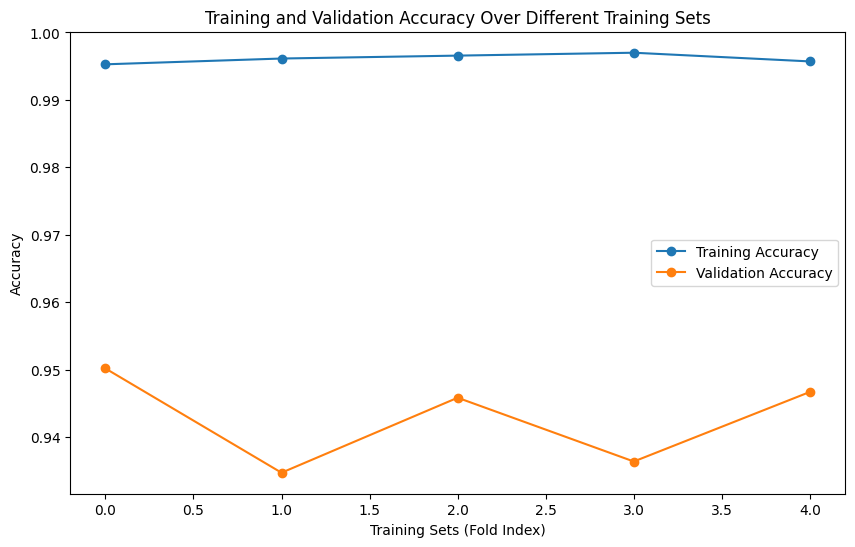

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialize model and KFold
model = RandomForestClassifier(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

train_accuracies = []
val_accuracies = []

# Loop through each training size
for train_index, val_index in cv.split(X):
    # Use .iloc to select rows based on integer indices
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Store accuracies
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Different Training Sets')
plt.xlabel('Training Sets (Fold Index)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold, cross_validate



# Define multiple scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0),
    'hamming_loss': make_scorer(hamming_loss)
}

# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

# Print average scores across folds
for metric in scoring.keys():
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.capitalize()}: {mean_score:.4f}")


Precision: 0.9774
Recall: 0.9008
F1: 0.9291
Hamming_loss: 0.0028


**Results**
*   Obtained **Hamming_loss** as 0.0028 which is the fraction of incorrect labels, accounting for both false positives and false negatives.
*   Precision of 0.9789 which ensures the model isn't over-predicting genres.
*  Recall as 0.89 which ensures it captures all relevant genres.





